# <b style='color:blue;'> Random Forest </b>
* Este Jupyter tem como função treinar um `Random Forest` com os melhores parametros determinados por um `RandomSearch`.

-> Dataset completo com voluntários femininos, sem outliers para predizer a semana.

---

Bibliotecas/Módulos

In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle as pkl
import seaborn as sns
import sys

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, matthews_corrcoef, classification_report, f1_score, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.multiclass import OneVsRestClassifier

Configurações dos logs

In [2]:
logger = logging.getLogger("SVM")
logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler(sys.stderr)
formatter = logging.Formatter('%(name)s - %(levelname)s - [+] ------- %(message)s -------') 
handler.setFormatter(formatter)
logger.handlers = [handler]

Cores

In [3]:
RED = "\033[1;31m"
BLUE = "\033[1;34m"
GREEN = "\033[1;32m"
PINK = "\033[1;45m"
HEADER = '\033[95m'
OKBLUE = '\033[94m'
OKCYAN = '\033[96m'
OKGREEN = '\033[92m'
WARNING = '\033[93m'
FAIL = '\033[91m'
ENDC = '\033[0m'
BOLD = '\033[1m'
UNDERLINE = '\033[4m'
MAG = "\033[1;45m"

---

## Preparando os dados

In [4]:
df = pd.read_csv("dados_FEM_10_voluntarios_c_semanas_15_sinais_noout.csv")

In [5]:
df.sample()

,0,1,2,3,4,5,6,7,8,9,...,1992,1993,1994,1995,1996,1997,1998,1999,label,semana
16101,-15,64,-22,2,-12,-16,-6,-2,-29,-2,...,17,-18,32,-16,-26,-24,42,10,1,4


Verificando tamanho do dataset

In [6]:
len(df)

18000

* Seleção da variável target e das features

In [7]:
y = df["semana"]

In [8]:
df = df.drop(["semana"], axis=1)

#### PCA
Aplicando o PCA para reduzir a dimensão dos dados.

In [9]:
pca = PCA(n_components=1000)

In [10]:
pca.fit(df)

PCA(n_components=1000)

In [11]:
%%time

pca_samples = pca.transform(df)

CPU times: user 16.1 s, sys: 5.01 s, total: 21.1 s
Wall time: 1.6 s


In [12]:
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-31.426972,19.593266,66.149497,5.087693,-145.755438,-60.110903,-95.581629,8.489667,-73.231320,-43.579136,...,-8.211093,9.166805,-1.582251,-9.737326,20.447125,1.387172,-25.677965,5.354503,11.283726,-15.186197
1,-67.161373,33.442037,43.310118,-14.236839,-144.593542,-12.403398,-98.242895,-2.547335,-69.538878,-37.210569,...,-0.013515,11.151926,-21.402216,-14.443621,12.160253,3.705141,-25.605870,2.332190,3.546148,-0.029490
2,-93.019930,35.557195,5.966039,-26.539077,-151.494378,32.550934,-112.608380,-15.639923,-59.108039,-28.130038,...,26.714494,14.877354,-21.795474,-18.334793,2.979366,-8.785094,-23.663926,-4.434815,-15.330769,4.074827
3,-114.755784,34.779378,-10.552657,-39.481854,-145.625364,72.526742,-111.402247,-35.211066,-48.914545,-12.286798,...,30.396661,14.444336,-25.446565,-17.119602,-1.435610,-3.385903,-32.703435,-8.487190,-27.367869,0.683482
4,-111.867249,44.544022,-26.877515,-47.197607,-135.394425,97.920772,-85.358632,-53.932529,-39.548346,-1.877483,...,37.173379,14.168641,-15.080305,-13.878028,-12.504133,4.964453,-13.820075,-1.006584,-39.968893,0.360752


In [13]:
len(ps)

18000

In [14]:
len(ps.columns)

1000

In [15]:
X = ps

Separando os dados em dados de treino e teste

In [16]:
x_treino, x_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.2, random_state=7)

---

## Treinamento

### Random Forest

In [17]:
def classificador(x_treino: np.array, y_treino: np.array, x_teste: np.array, y_teste: np.array):
    '''
        Treina um classificador com os melhores parametros possíveis.
        
        Params
        ------
        :x_treino: dados de treino
        :x_teste: dados de teste
        :y_treino: dados de treino -labels
        :y_teste: dados de treino - labels
    
        Return
        ------
        :RF: Modelo Random Forest treinado
        :resultados (matrix): métricas
    '''
    
    logger.info('Instanciando Random Forest')
    
    RF = OneVsRestClassifier(RandomForestClassifier(n_jobs= 1, n_estimators= 100, min_samples_leaf= 1))
       
    logger.info('Treinando Random Forest')
    RF.fit(x_treino, y_treino)
    
    logger.info('Predict')
    p = RF.predict_proba(x_teste)[:, 1]
    categorias = RF.predict(x_teste)
    
    logger.info('Métricas: \n \n')
    
    logger.info('Acurácia')
    acc = accuracy_score(y_teste, categorias)
    print(OKCYAN, "Acc \n" + str(acc) + "\n")
    
    logger.info("Mcc")
    mcc = matthews_corrcoef(y_teste, categorias)
    print(WARNING, "Mcc \n" + str(mcc) + "\n")
    
    logger.info("F1")
    f1 = f1_score(y_teste, categorias, average="weighted")
    print(GREEN, "F1 \n" + str(f1) + "\n")
    
    logger.info('Class Report')
    resultados = classification_report(y_teste, categorias)
    print(ENDC, "Class Report \n" + resultados + "\n")
    
    mat = confusion_matrix(y_teste, categorias)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
       
    return RF, resultados

SVM - INFO - [+] ------- Instanciando Random Forest -------
SVM - INFO - [+] ------- Treinando Random Forest -------
SVM - INFO - [+] ------- Predict -------
SVM - INFO - [+] ------- Métricas: 
 
 -------
SVM - INFO - [+] ------- Acurácia -------
SVM - INFO - [+] ------- Mcc -------
SVM - INFO - [+] ------- F1 -------
SVM - INFO - [+] ------- Class Report -------
SVM - INFO - [+] ------- Ok -------
SVM - INFO - [+] ------- Treino finalizado -------


 Acc 
0.6861111111111111

 Mcc 
0.5830830897360848

 F1 
0.6873571813993828

 Class Report 
              precision    recall  f1-score   support

           1       0.67      0.67      0.67       865
           2       0.60      0.73      0.66       890
           3       0.75      0.69      0.72       945
           4       0.74      0.66      0.70       900

    accuracy                           0.69      3600
   macro avg       0.69      0.69      0.69      3600
weighted avg       0.69      0.69      0.69      3600


CPU times: user 4min 1s, sys: 0 ns, total: 4min 1s
Wall time: 4min 1s


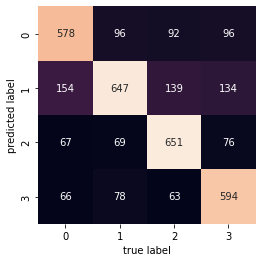

In [18]:
%%time

try:
    RF_cbow, resultados = classificador(
                        x_treino,
                        y_treino,
                        x_teste,
                        y_teste)

except Exception as error:
    logger.warning('Aconteceu algum problema...')
    logger.critical(error)

else:
    logger.info('Ok')
    
finally:
    logger.info('Treino finalizado')

In [19]:
print(resultados)

'              precision    recall  f1-score   support\n\n           1       0.67      0.67      0.67       865\n           2       0.60      0.73      0.66       890\n           3       0.75      0.69      0.72       945\n           4       0.74      0.66      0.70       900\n\n    accuracy                           0.69      3600\n   macro avg       0.69      0.69      0.69      3600\nweighted avg       0.69      0.69      0.69      3600\n'

---

#### Exportando modelo

In [21]:
pkl.dump(RF_cbow, open('modelos/rf_dados_FEM_10_voluntarios_c_semanas_15_sinais_noout.pkl', 'wb'))